# Modeling Slash-and-burn Agriculture in Colonial Brazil

*Leonardo Barleta, Evan Yong-Seok Kim, Isabela Barros David Rodrigues*<br>
Center for Spatial and Textual Analysis (CESTA), Stanford University

This notebook uses agent-based modeling to simulate slash-and-burn agriculture in São Paulo, Brazil, from the late 16th to the 18th centuries. Slash-and-burn agriculture -- also known as itinerant, shifiting, swidden, or (in Brazil) *coivara* and *roça de toco* -- is a method of farming in which farmers burn tracts of forest to clear and fertilize the terrain. Because the fertility of the soil lasts only a few seasons, farmers have to move periodically in search of new areas with lush vegetation, creating a cycle of mobility and deforestation. This simulation serves to examine the adoption of slash-and-burn techniques by Portuguese colonists, assessing the scale of environmental impact produced by the colonization and the patterns of geographic mobility created by this technique.

Current version: 3.0.0 (29/10/2019)

Previous milestones:

- Oct 2019 - Code refactored and first results were generated for analysis
- Summer 2019 - Python+Jupyter notebook completely revamped by Evan, generating version 3
- Spring 2019 - Version 2.x adapted previous model to Python+Jupyter 
- Winter 2019 - Version 1.x was creasted by Bela and Leo using NetLogo  

# Setup

In [1]:
#Libraries
from tqdm import tqdm_notebook, tnrange
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random, imageio, os, datetime, math, sys, pickle

In [2]:
# PARAMETERS OF THE SIMULATION

# name of the simulation
NAME = 'testing'

# initial number of households
HOUSEHOLDS = 240

# annual rate of population growth
POP_GROWTH = 2.6 #.5%/year -- rate of growth

# number of years  that one can cultivate a plot of land
FARMING_PERIOD = 4

# number of years that a plot of land needs to recycle
RECYCLING_PERIOD = 30

# initial and end year
INITIAL_YEAR = 1690
END_YEAR = 1798

# search radius
MAX_DISTANCE = 30

# percentage of unavailable land
UNAVAILABLE_PCT = 0.5

# initial town (Y,X)
INITIAL_TOWN = (550, 585)

In [3]:
# Plots
available = 1 #green
unusable = 2 #black
use = 3 #redish orange
recycling = 4 #brown
urban = 5 # yellow
unavailable = 6 #grey

colors = {
    available: (236, 255, 179),
    unusable: (50,50,50),
    use: (255,110,50),
    recycling: (125,90,30),
    urban: (255,255,0),
    unavailable: (100,100,100),
}

# other variables
pop_increment = 0.0
new_hometown = False

# Functions

In [93]:
def setup():
    global status, countdown, occupant, agents, towns, mydir, report, simulation
    
    ### ENVIRONMENT ###
    simulation = NAME +'_'+ datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
    mydir = os.path.join(os.getcwd(), 'simulations', simulation)
    os.makedirs(mydir)
    
    report = pd.DataFrame(columns=['year', 'population', 'towns', 'using', 'recycling', 'max_distance'])
    
    ### SETTING UP SPACE ###
    
    # loading basemap
    backland = Image.open("available_land2.jpg").convert('RGB')
    backland_matrix = np.array(backland)
    n,m = backland.size #n - width, m - height, use m for rows, n for columns
        
    # creating basic matrices
    status = np.zeros((m,n), dtype=np.int16) # 
    countdown = np.negative(np.ones((m,n), dtype=np.int16)) #starts from 4, then counts down
    occupant = np.negative(np.ones((m,n), dtype=np.int16)) #starts from 4, then counts down
    #occupant = np.zeros((m,n), dtype=np.int16) #has ID
    
    # TODO: replace for progress_apply
    for j in tnrange(m, desc='setting up plots'):
        for k in range(0, n):
            if backland_matrix[j][k][0] == 0:
                status[j][k] = unusable    
            else:
                status[j][k] = available
   
    
    
    # generating random unavailable plots
    status[status == 1] = np.random.choice([available, unavailable],
                                           size=status[status == 1].size, 
                                           p=[1-UNAVAILABLE_PCT,UNAVAILABLE_PCT])

    
    # create dataframe with list of towns, populating with initial town
    towns = pd.DataFrame([[INITIAL_TOWN[0], INITIAL_TOWN[1]]], columns=['X', 'Y'])
    status[(INITIAL_TOWN[1],INITIAL_TOWN[0])] = urban
    
    ### SETTING UP AGENTS ###
    
    # creating agents dataframe
    agents = pd.DataFrame(index=range(0,HOUSEHOLDS), columns=['Current X', 'Current Y', 'Hometown X', 'Hometown Y', 'Hometown ID'], dtype='int16')
    agents[['Current X', 'Current Y', 'Hometown X', 'Hometown Y', 'Hometown ID']] = [INITIAL_TOWN[0],INITIAL_TOWN[1],INITIAL_TOWN[0],INITIAL_TOWN[1],0]
    agents['Current X'] = agents['Current X'].astype('int') 
    agents['Current Y'] = agents['Current Y'].astype('int') 
    agents['Hometown X'] = agents['Hometown X'].astype('int') 
    agents['Hometown Y'] = agents['Hometown Y'].astype('int') 
    agents['Hometown ID'] = agents['Hometown ID'].astype('int') 
    
    # rellocate
    tqdm_notebook().pandas(desc="rellocating agents", leave=False)
    agents.progress_apply(rellocate, axis=1)
    
    return True

In [92]:
# This function rellocates agents to the nearest available plot
# and updates the status of the plots

def rellocate(agent):
    global status, agents
    
    # find the nearest available plot
    coords = find_nearest(agent[['Hometown Y', 'Hometown X']], available)
    
    # changing matrices conditions
    # new plot
    status[coords] = use
    countdown[coords] = random.randint(FARMING_PERIOD - 1, FARMING_PERIOD + 2)
    occupant[coords] = agent.name
    
    # old plot, change to recycling case using
    current = (agents.loc[agent.name, 'Current Y'], agents.loc[agent.name, 'Current X'])
    if status[current] == use:
        status[current] = recycling
        countdown[current] = random.randint(RECYCLING_PERIOD - 5, RECYCLING_PERIOD + 6)
        occupant[current] = -1
        
    agents.loc[agent.name, 'Current X'] = coords[1]
    agents.loc[agent.name, 'Current Y'] = coords[0]
        
    return True

In [42]:
# This function finds the nearest plot in the matrix 'status' 
# that had value equals 'val', using Euclidean distance
# pos (list) = [current Y, current X]
# val (int) = 1

def find_nearest(pos, val = available): 
    global status
    
    # TODO: to improve performance, we can restrict the area of this search
    positions = np.where(status == val)
    
    y,x = positions #x = x value of status array, y = y value of status array, such that the status is available
    
    dx = abs(pos[1] - x)  # Horizontal distance
    dy = abs(pos[0] - y)  # Vertical distance
    
    dist = np.sqrt(dx ** 2 + dy ** 2) # euclidean distance
    min_pos = np.argmin(dist)  # This method will only return the first occurrence (!)
    coords = y[min_pos], x[min_pos]
    return coords

In [43]:
'''    
old code for new towns

if not HOMETOWN_GENERATED: #max of 1 hometown made per year
    horz_distance = (dpopulation.iloc[ID, 0] - dpopulation.iloc[ID, 2]).abs()
    vert_distance = (dpopulation.iloc[ID, 1] - dpopulation.iloc[ID, 3]).abs()
    distance = np.sqrt(horz_distance ** 2 + vert_distance ** 2)
    if distance > MAX_DISTANCE * 1.5:
        #the plot they are in should create a new town in the plot they are in. 
        dpopulation.iloc[ID, 2] = coord[0] #update the hometown X 
        dpopulation.iloc[ID, 3] = coord[1] #update the hometown Y
        towns.append(coord)
        HOMETOWN_GENERATED = True'''

'    \nold code for new towns\n\nif not HOMETOWN_GENERATED: #max of 1 hometown made per year\n    horz_distance = (dpopulation.iloc[ID, 0] - dpopulation.iloc[ID, 2]).abs()\n    vert_distance = (dpopulation.iloc[ID, 1] - dpopulation.iloc[ID, 3]).abs()\n    distance = np.sqrt(horz_distance ** 2 + vert_distance ** 2)\n    if distance > MAX_DISTANCE * 1.5:\n        #the plot they are in should create a new town in the plot they are in. \n        dpopulation.iloc[ID, 2] = coord[0] #update the hometown X \n        dpopulation.iloc[ID, 3] = coord[1] #update the hometown Y\n        towns.append(coord)\n        HOMETOWN_GENERATED = True'

In [44]:
def ticks(): #redo it with numpy controls
    countdown[countdown != 0] -= 1 #subtracts a value of 1 from all nonzero countdown values

In [45]:
def time_control():
    cond1_idx = np.where((status == use) & (countdown <= 0))
    cond2_idx = np.where((status == recycling) & (countdown <= 0))
    
    status[cond1_idx] = recycling
    countdown[cond1_idx] = random.randint(RECYCLING_PERIOD - 5, RECYCLING_PERIOD + 6)
    [rellocate(agents.iloc[occupant[i][j]]) for i,j in zip(*cond1_idx)] 
    occupant[cond1_idx] = 0
    
    status[cond2_idx] = available
    countdown[cond2_idx] = -1

In [46]:
def pop_update():
    global agents, towns
    
    # calculate the number of new people based on existing increment plus population growth    
    increment = pop_increment + (POP_GROWTH/100 * len(agents.index))
    new_people = math.floor(increment)
    
    #create new people
    start_id = len(agents.index)
    
    for x in range(start_id, start_id+new_people):
        # randomly select hometown
        hometown = towns.iloc[np.random.choice(towns.index)]
        
        #create new person nearest to the hometown
        person = {'Current X': hometown['X'],
                 'Current Y': hometown['Y'],
                 'Hometown X': hometown['X'],
                 'Hometown Y': hometown['Y'],
                 'Hometown ID': hometown.name}
        
        agents = agents.append(person, ignore_index=True)
        
        #reallocate to nearest town
        rellocate(agents.iloc[x])
    
    return increment - new_people
    

In [47]:
def get_furthest_distance():
    global MAX_DISTANCE

    horz_distances = (agents['Current X'] - agents['Hometown X']).abs()
    vert_distances = (agents['Current Y'] - agents['Hometown Y']).abs()
    distances = np.sqrt(horz_distances ** 2 + vert_distances ** 2).values.tolist()
    
    furthest = max(distances)
    return furthest

In [48]:
def generate_frame(year):
    global status
    
    m,n = status.shape
    arr = np.empty((m,n,3), dtype=object)
    
    ## progress_apply?
    for j in tnrange(m, desc='generating image', leave=False):
        for k in range(0, n):
            arr[j,k] = colors[status[j,k]]
    
    
    img = Image.fromarray(arr.astype('int8'), 'RGB')
    
    d = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 54)
    d.text((n-150, m-80), str(year), fill=(255,255,255), font=font)
    
    return img

In [49]:
def create_gif(simulation):
    frames = []
    filenames = os.listdir(mydir)
    filenames = [f.lower() for f in filenames]
    for filename in tqdm_notebook(sorted(filenames), desc='creating gif'):
        frames.append(imageio.imread(os.path.join(mydir, filename)))
    imageio.mimsave(os.path.join('simulations', simulation + '.gif'), frames)
    return True

# Simulations

## Simulation 1

-- describe the simulation here

In [103]:
# PARAMETERS OF THE SIMULATION
NAME = 'solcha5'
HOUSEHOLDS = 240

# TODO
POP_GROWTH = {
    1590: 2.6,
    1687: 1.1
}

POP_GROWTH = 0
FARMING_PERIOD = 4
RECYCLING_PERIOD = 30
INITIAL_YEAR = 1590
END_YEAR = 1765
MAX_DISTANCE = 30
UNAVAILABLE_PCT = 0
INITIAL_TOWN = (550, 585)

parameters = {
    'name': NAME,
    'households': HOUSEHOLDS,
    'pop_growth': POP_GROWTH,
    'farming_period': FARMING_PERIOD,
    'recycling_period': RECYCLING_PERIOD,
    'initial_year': INITIAL_YEAR,
    'end_year': END_YEAR,
    'max_distance': MAX_DISTANCE,
    'unavailable_pct': UNAVAILABLE_PCT,
    'initial_town': INITIAL_TOWN,
    'obs': 'Simulation for SOLCHA paper. Normal population (240 households), with 100% of available land but no population growth. '
}

In [121]:
setup()
furthest_distance_list = []
current_year = INITIAL_YEAR

for v in tnrange(END_YEAR - INITIAL_YEAR, desc='ticks'):
    # TODO: join functions
    ticks()
    time_control()
    
    #TODO: fix this
    #if current_year == 1687:
    #    POP_GROWTH = 1.1
        
    pop_increment = pop_update()
    
    # save frame
    frame = generate_frame(current_year)
    frame.save(mydir + '/' + str(current_year) + '.jpg')
    
    add = pd.Series([current_year, 
               len(agents), 
               len(towns), 
               len(np.where(status == use)[0]), 
               len(np.where(status == recycling)[0]), 
               round(get_furthest_distance())],
              ['year', 'population', 'towns', 'using', 'recycling', 'max_distance'])
    
    
    # TODO FOR REPORT
    # ADD NEW PLOTS THAT ARE INCLUDED AND THOSE THAT WERE REUSED AFTER FALLOWING
    # ADD AVERAGE DISTANCE TO HOMETOWN
    # pickle and save every state?
    
    report = report.append([add])
    current_year = current_year + 1
    
create_gif(simulation)

## Saving data
pickle.dump(parameters, open(os.path.join(mydir, "parameters.p" ), "wb"))
report.to_pickle(os.path.join(mydir, 'report.p'))

print('done')

KeyboardInterrupt: 

# Analysis

In [123]:
mydir1 = 'G:\\My Drive\\academic\\doctorate\\dissertation\\gis\\spatial simulation\\gif_notebook [8-30-19]\\simulations\\solcha4_2019-10-28_14-40'
mydir2 = 'G:\\My Drive\\academic\\doctorate\\dissertation\\gis\\spatial simulation\\gif_notebook [8-30-19]\\simulations\\solcha5_2019-10-28_15-43'
mydir3 = 'G:\\My Drive\\academic\\doctorate\\dissertation\\gis\\spatial simulation\\gif_notebook [8-30-19]\\simulations\\solcha5_2019-10-28_16-22'

mydir1, mydir2,mydir3

('G:\\My Drive\\academic\\doctorate\\dissertation\\gis\\spatial simulation\\gif_notebook [8-30-19]\\simulations\\solcha4_2019-10-28_14-40',
 'G:\\My Drive\\academic\\doctorate\\dissertation\\gis\\spatial simulation\\gif_notebook [8-30-19]\\simulations\\solcha5_2019-10-28_15-43',
 'G:\\My Drive\\academic\\doctorate\\dissertation\\gis\\spatial simulation\\gif_notebook [8-30-19]\\simulations\\solcha5_2019-10-28_16-22')

In [129]:
parameters1 = pickle.load(open(os.path.join(mydir1, "parameters.p" ), "rb"))
report1 = pd.read_pickle(os.path.join(mydir1, 'report.p'))

parameters2 = pickle.load(open(os.path.join(mydir2, "parameters.p" ), "rb"))
report2 = pd.read_pickle(os.path.join(mydir2, 'report.p'))

parameters3 = pickle.load(open(os.path.join(mydir3, "parameters.p" ), "rb"))
report3 = pd.read_pickle(os.path.join(mydir3, 'report.p'))

parameters3, report3

({'name': 'solcha5',
  'households': 240,
  'pop_growth': 0,
  'farming_period': 4,
  'recycling_period': 30,
  'initial_year': 1590,
  'end_year': 1765,
  'max_distance': 30,
  'unavailable_pct': 0,
  'initial_town': (550, 585),
  'obs': 'Simulation for SOLCHA paper. Normal population (240 households), with 100% of available land but no population growth. '},
     year population towns using recycling max_distance
 0   1590        240     1   240         0            9
 0   1591        240     1   240         0            9
 0   1592        240     1   240        51            9
 0   1593        240     1   240       116           11
 0   1594        240     1   240       173           11
 0   1595        240     1   240       250           13
 0   1596        240     1   240       282           13
 0   1597        240     1   240       322           14
 0   1598        240     1   240       381           14
 0   1599        240     1   240       434           15
 0   1600        240 

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

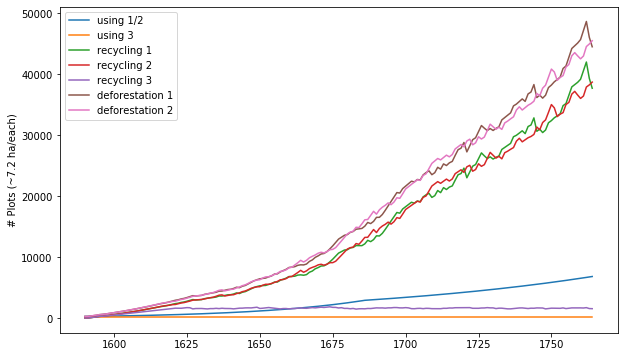

In [120]:
%matplotlib inline

g1 = plt.figure(1)
plt.figure(figsize=(10,6))
plt.plot(report1['year'], report1['using'], label='using 1/2')
plt.plot(report3['year'], report3['using'], label='using 3')
plt.plot(report1['year'], report1['recycling'], label='recycling 1')
plt.plot(report2['year'], report2['recycling'], label='recycling 2')
plt.plot(report3['year'], report3['recycling'], label='recycling 3')
plt.plot(report1['year'], report1['recycling']+report1['using'], label='deforestation 1')
plt.plot(report1['year'], report2['recycling']+report2['using'], label='deforestation 2')
plt.ylabel('# Plots (~7.2 ha/each)')
#plt.title('Plot usage')
plt.legend()
#plt.grid()
g1.show()

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

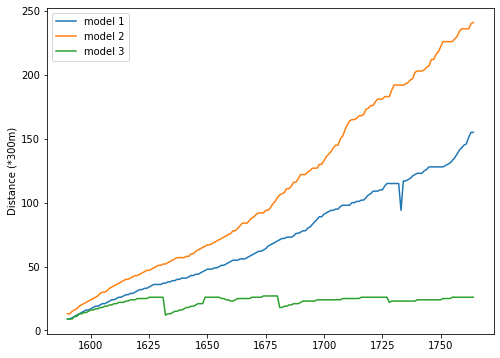

In [130]:
%matplotlib inline

g2 = plt.figure(2)
plt.figure(figsize=(8,6))
plt.plot(report1['year'], report1['max_distance'], label='model 1')
plt.plot(report2['year'], report2['max_distance'], label='model 2')
plt.plot(report3['year'], report3['max_distance'], label='model 3')
plt.ylabel('Distance (*300m)')
plt.legend()
g2.show()

In [115]:
report3['max_distance'].max()

27

In [97]:
countdown[580:590, 545:555]

array([[26,  1, 23, 23,  1, 23, 34, 23, 23, 26],
       [23, 34, 26, 26, 23, 34, 23, 34, 26,  1],
       [23, 34, 26, 26, 23, 34, 23, 34, 23, 34],
       [ 1, 34, 26,  1, 26, 23, 26, 23,  1, 26],
       [26, 34,  1, 23, 34,  1, 23, 34, 26, 26],
       [34, 34, 34, 23, 26, -6, 23, 23, 23, 34],
       [23,  1, 26, 23, 23, 26, 26, 26, 26,  1],
       [34, 23,  1, 23, 23,  1,  1, 23,  1,  1],
       [26, 34, 26,  1, 26, 34,  1, 26, 23, 23],
       [23, 26, 23, 23, 23, 26,  1, 23, 23, 23]], dtype=int16)

## Performance test

In [65]:
test = np.ones(shape=(1000,1000))
x,y = test.shape

def multiply(v):
    return v * np.random.randint(5)

f = lambda v: v * np.random.randint(5)
vectorized = np.vectorize(f)

In [73]:
%%time
for i in range(0,x):
    for j in range(0,y):
        test[i,j] = test[i,j] * np.random.randint(5)

Wall time: 1.56 s


In [78]:
%%time
test = vectorized(test)

Wall time: 1.15 s
